# Análise de Sobrevivência: 6MP vs Placebo

Este notebook apresenta a resolução dos itens solicitados:
1. Estimadores produto-limite (Kaplan–Meier) e Nelson–Aalen para os dois grupos (6MP e Placebo).
2. Variâncias dos estimadores de Kaplan–Meier e intervalos de confiança.
3. Gráficos das curvas de sobrevivência estimadas.
4. Cálculo do tempo médio de vida dos pacientes para os dois grupos (RMST).
5. Conclusões.
6. Construção do gráfico TTT plot e interpretação da função de risco.


In [17]:
# !pip install lifelines
# !pip install reliability

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from lifelines.utils import survival_table_from_events, restricted_mean_survival_time

## 1. Definição dos Dados

Preparar os vetores de tempo e status (evento/censura) para os grupos Droga (6MP) e Placebo.


In [18]:
times_droga = np.array([6, 6, 6, 6, 7, 9, 10, 10, 11, 13, 16, 17, 19, 20, 22, 23, 25, 32, 32, 34, 35])
status_droga = np.array([1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0])

times_placebo = np.array([1, 1, 2, 2, 3, 4, 4, 5, 5, 8, 8, 8, 8, 11, 11, 12, 12, 15, 17, 22, 23])
status_placebo = np.ones_like(times_placebo)

df_droga = pd.DataFrame({'time': times_droga, 'status': status_droga})
df_placebo = pd.DataFrame({'time': times_placebo, 'status': status_placebo})

df_droga.head(), df_placebo.head()


(   time  status
 0     6       1
 1     6       1
 2     6       1
 3     6       0
 4     7       1,
    time  status
 0     1       1
 1     1       1
 2     2       1
 3     2       1
 4     3       1)

## 2. Estimador Kaplan–Meier para Cada Grupo

Ajustar e exibir as tabelas de sobrevivência (incluindo variâncias e intervalos de confiança) para cada grupo usando o Kaplan–Meier.


In [19]:
kmf_droga = KaplanMeierFitter()
kmf_droga.fit(durations=times_droga, event_observed=status_droga, label='Droga (6MP)')

kmf_placebo = KaplanMeierFitter()
kmf_placebo.fit(durations=times_placebo, event_observed=status_placebo, label='Placebo')

table_droga = survival_table_from_events(df_droga['time'], df_droga['status'])
table_placebo = survival_table_from_events(df_placebo['time'], df_placebo['status'])
table_droga, table_placebo


(          removed  observed  censored  entrance  at_risk
 event_at                                                
 0               0         0         0        21       21
 6               4         3         1         0       21
 7               1         1         0         0       17
 9               1         0         1         0       16
 10              2         1         1         0       15
 11              1         0         1         0       13
 13              1         1         0         0       12
 16              1         1         0         0       11
 17              1         0         1         0       10
 19              1         0         1         0        9
 20              1         0         1         0        8
 22              1         1         0         0        7
 23              1         1         0         0        6
 25              1         0         1         0        5
 32              2         0         2         0        4
 34           

### 2.1 Variâncias e Intervalos de Confiança do Kaplan–Meier

As variâncias e intervalos de confiança de 95% estão disponíveis nos atributos do objeto ajustado.


In [20]:
km_droga_df = kmf_droga.survival_function_.reset_index()
km_droga_df.columns = ['timeline', 'survival_prob_droga']
ci_droga = kmf_droga.confidence_interval_

km_placebo_df = kmf_placebo.survival_function_.reset_index()
km_placebo_df.columns = ['timeline', 'survival_prob_placebo']
ci_placebo = kmf_placebo.confidence_interval_

print(f'{km_droga_df.head()} \n')
print(f'{ci_droga.head()} \n')
print(f'{km_placebo_df.head()} \n')
print(f'{ci_placebo.head()} \n')

   timeline  survival_prob_droga
0         0                    1
1         6             0.857143
2         7             0.806723
3         9             0.806723
4        10             0.752941 

    Droga (6MP)_lower_0.95  Droga (6MP)_upper_0.95
0                        1                       1
6                 0.619718                0.951552
7                 0.563147                0.922809
9                 0.563147                0.922809
10                  0.5032                0.889362 

   timeline  survival_prob_placebo
0         0                      1
1         1               0.904762
2         2               0.809524
3         3               0.761905
4         4               0.666667 

   Placebo_lower_0.95  Placebo_upper_0.95
0                   1                   1
1            0.670046            0.975294
2            0.568905            0.923889
3            0.519391            0.893257
4             0.42535            0.825044 



### 2.2 Curvas de Sobrevivência Kaplan–Meier

Plotar as curvas KM com intervalo de confiança.


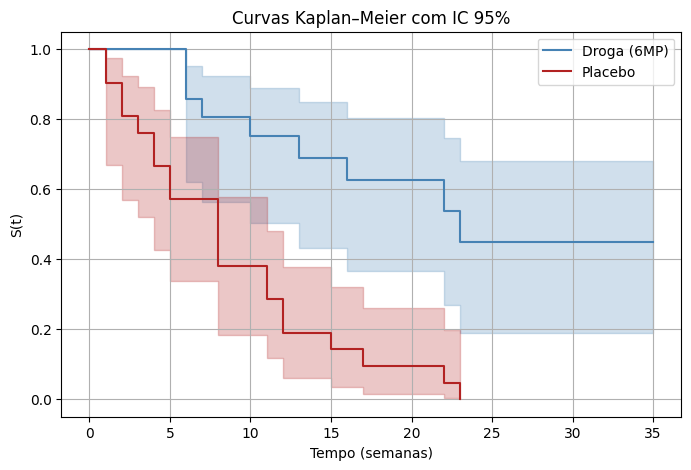

In [21]:
plt.figure(figsize=(8, 5))
ax = plt.subplot(111)
kmf_droga.plot_survival_function(ax=ax, ci_show=True, color='steelblue')
kmf_placebo.plot_survival_function(ax=ax, ci_show=True, color='firebrick')
plt.title('Curvas Kaplan–Meier com IC 95%')
plt.xlabel('Tempo (semanas)')
plt.ylabel('S(t)')
plt.legend()
plt.grid(True)
plt.show()


## 3. Estimador Nelson–Aalen

Ajustar e mostrar a função de risco acumulada para cada grupo.


In [22]:
naf_droga = NelsonAalenFitter()
naf_droga.fit(durations=times_droga, event_observed=status_droga, label='Droga (6MP)')

naf_placebo = NelsonAalenFitter()
naf_placebo.fit(durations=times_placebo, event_observed=status_placebo, label='Placebo')

haz_droga = naf_droga.cumulative_hazard_.reset_index()
haz_placebo = naf_placebo.cumulative_hazard_.reset_index()
print(f'{haz_droga.head()} \n')
print(f'{haz_placebo.head()} \n')

   timeline  Droga (6MP)
0         0            0
1         6     0.150251
2         7     0.209074
3         9     0.209074
4        10     0.275741 

   timeline  Placebo
0         0        0
1         1 0.097619
2         2 0.205806
3         3  0.26463
4         4 0.393796 



### 3.1 Gráfico da Hazard Acumulada (Nelson–Aalen)


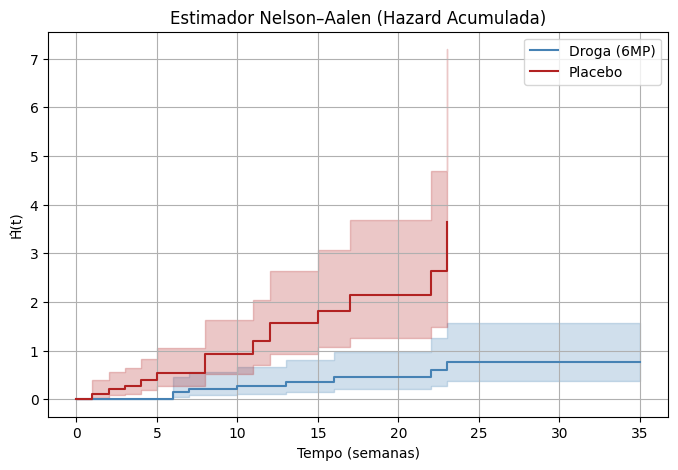

In [23]:
plt.figure(figsize=(8, 5))
ax = plt.subplot(111)
naf_droga.plot_cumulative_hazard(ax=ax, color='steelblue')
naf_placebo.plot_cumulative_hazard(ax=ax, color='firebrick')
plt.title('Estimador Nelson–Aalen (Hazard Acumulada)')
plt.xlabel('Tempo (semanas)')
plt.ylabel('Ĥ(t)')
plt.legend()
plt.grid(True)
plt.show()


## 4. Tempo Médio de Vida (RMST)

Calcular a área sob a curva de sobrevivência (RMST) até o maior tempo comum.


In [24]:
tau = min(times_droga.max(), times_placebo.max())

rmst_droga = restricted_mean_survival_time(kmf_droga, t=tau)
rmst_placebo = restricted_mean_survival_time(kmf_placebo, t=tau)
print(f"Tau (semanas): {tau}")
print(f"RMST Droga: {rmst_droga:.2f}")
print(f"RMST Placebo: {rmst_placebo:.2f}")


Tau (semanas): 23
RMST Droga: 17.91
RMST Placebo: 8.67


## 5. Conclusões

- A curva de sobrevivência do grupo **Droga (6MP)** está consistentemente acima da curva do **Placebo**, indicando melhor sobrevida.
- O estimador de Nelson–Aalen (hazard acumulada) cresce mais rapidamente para o Placebo, sugerindo taxa de falha maior em comparação com a Droga.
- O RMST (tempo médio de vida restrito) calculado até τ confirma que o tratamento 6MP oferece maior tempo médio de vida comparado ao placebo.


## 6. Gráfico TTT Plot

Construir o TTT Plot (Total Time on Test) e interpretar a função de risco para os dois grupos.


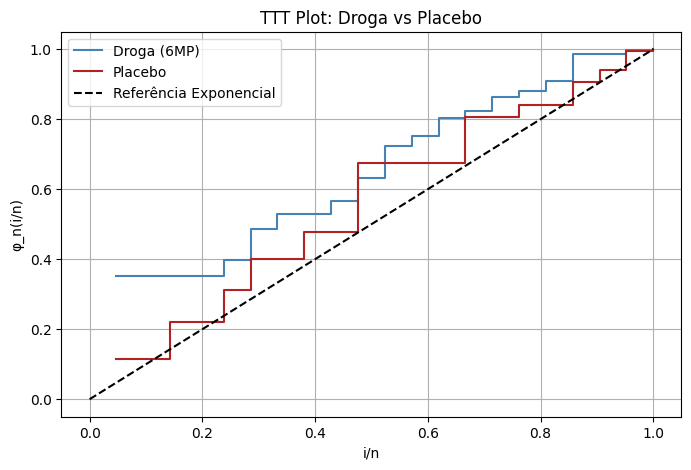

In [28]:
def compute_ttt(times):
    n = len(times)
    sorted_times = np.sort(times)
    S_total = sorted_times.sum()
    phi = []
    for i in range(1, n+1):
        T_i = sorted_times[i-1]
        soma_i = sorted_times[:i].sum()
        phi.append((soma_i + (n - i) * T_i) / S_total)
    return np.arange(1, n+1) / n, np.array(phi)

indices_droga, phi_droga = compute_ttt(times_droga)
indices_placebo, phi_placebo = compute_ttt(times_placebo)

plt.figure(figsize=(8, 5))
plt.step(indices_droga, phi_droga, where='post', color='steelblue', label='Droga (6MP)')
plt.step(indices_placebo, phi_placebo, where='post', color='firebrick', label='Placebo')
plt.plot([0, 1], [0, 1], 'k--', label='Referência Exponencial')
plt.xlabel('i/n')
plt.ylabel('φ_n(i/n)')
plt.title('TTT Plot: Droga vs Placebo')
plt.legend()
plt.grid(True)
plt.show()


Ambas as curvas estão consistentemente acima da diagonal, indicando taxa de falha crescente (IFR) em ambos os grupos. No entanto, a curva do grupo tratado com 6-mercaptopurina se afasta mais da reta de referência do que a do placebo, o que sugere que o risco de falha aumenta de forma mais acentuada para quem recebeu a droga.